In [143]:
import re
import random
import pandas as pd
import hashlib

In [144]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [145]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Debugging in VS Code,34.446894,34.446894,34.446894,1
Azure VM + Developer,59.665037,1.754854,5.862078,34
Finance Junk,89.908720,44.954360,49.084037,2
"Jane Eyre, Bronte",264.808779,33.101097,49.911224,8
Email Auth and Security,365.625840,60.937640,116.060605,6
TSQL,429.103660,17.879319,26.682431,24
Azure AD Authentication,686.485800,57.207150,128.614461,12
RAG Project,746.744949,82.971661,236.354572,9
Logging in Python,798.072642,57.005189,98.238667,14
Azure Private DNS,1358.918106,71.522006,140.819945,19


# Histogram

sum of ages: ~44404.90


<Axes: >

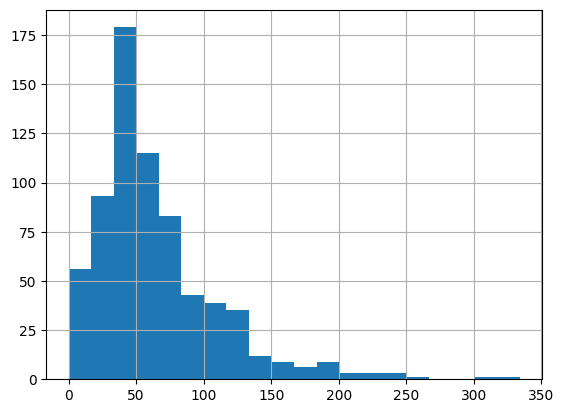

In [146]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~44404.90


<Axes: >

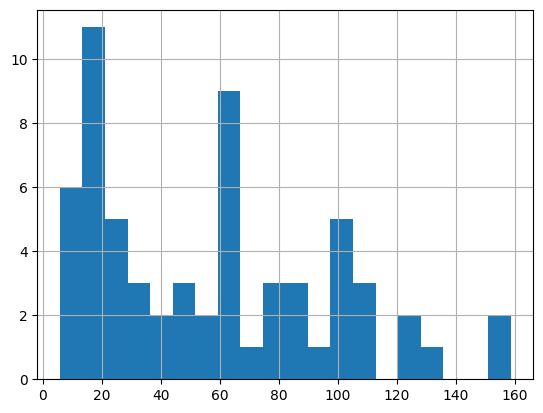

In [147]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [148]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [149]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [150]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [151]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [152]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [153]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [154]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [155]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [156]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [157]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [158]:
n=5
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 691
Total card age: 44404.90


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
223,Debugging in VS Code,Step Over\nA debugging feature that allows you...,e8a81b42a0247e7bc1a28364d9d8cc14,34.446894,34.446894,34.446894,34.446894,0.875725,1,0,0,-34.446894
222,Finance Junk,Interval Funds Carry Redemption Risk:\nBecause...,03e0916a4861f49d3b031e614386fcae,49.084037,44.954360,49.084037,89.908720,0.378152,2,0,0,-49.084037
443,Finance Junk,Interval Funds Generally Have Higher Fees and ...,39309824a2a0864d72c9c7e2ea997106,40.824683,44.954360,49.084037,89.908720,0.378152,2,1,0,-40.824683
217,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,116.060605,60.937640,116.060605,365.625840,0.809618,6,0,0,-116.060605
438,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,82.675027,60.937640,116.060605,365.625840,0.809618,6,1,0,-82.675027
653,Email Auth and Security,MX Toolbox\n\nAn online suite of tools for dia...,e9ebe1455842da03c6a7da1503e46e12,61.347638,60.937640,116.060605,365.625840,0.809618,6,2,0,-61.347638
218,Email Auth and Security,BIMI (Brand Indicators for Message Identificat...,2108ca953bb72f3c995be925bc4f8e9e,48.973819,60.937640,116.060605,365.625840,0.809618,6,3,0,-48.973819
439,Email Auth and Security,PGP (Pretty Good Privacy)\n\nA data encryption...,e43853f9bc2f7722fa2b49997002d648,34.578350,60.937640,116.060605,365.625840,0.809618,6,4,0,-34.578350
219,"Jane Eyre, Bronte",Salubrious\n(suh-LOO-bree-uhs) Describing some...,a4e97a6bcfb2423b479db36526595e42,49.911224,33.101097,49.911224,264.808779,0.665138,8,0,0,-49.911224
440,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,44.698205,33.101097,49.911224,264.808779,0.665138,8,1,0,-44.698205



## Random

In [159]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [160]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
659,Azure VM + Developer,Custom Script Extension\nA VM extension that a...,d3d8dede8b8008226b89c8604b75aac4,0.019263,1.754854,5.862078,59.665037,0.71678,34,33,6,-0.019263
689,Azure VM + Developer,Language Server Protocol (LSP)\nA communicatio...,78474be23aee1e1a6f611ef57c633fc6,0.136056,1.754854,5.862078,59.665037,0.71678,34,32,6,-0.136056
666,Azure VM + Developer,Remote Development\nA workflow where the code ...,8768fbbd3be8e62c25be8705689bbc02,0.151328,1.754854,5.862078,59.665037,0.71678,34,31,6,-0.151328
682,Azure VM + Developer,Dependency Management\nThe process of tracking...,774acfd871be251904fda0a918338ef6,0.166079,1.754854,5.862078,59.665037,0.71678,34,30,6,-0.166079
690,Azure VM + Developer,12-Factor App\nA set of best practices for bui...,7335f65e5504783dbbd6a4463ac255f3,0.189792,1.754854,5.862078,59.665037,0.71678,34,29,5,-0.189792
679,Azure VM + Developer,Build Tool\nA program used to automate the com...,5b92559a8c128584525a8a282d878e5e,0.202173,1.754854,5.862078,59.665037,0.71678,34,28,5,-0.202173
657,Azure VM + Developer,Availability Set\nA logical grouping that ensu...,350398e175cde0432245dc73fe9bbebc,0.206750,1.754854,5.862078,59.665037,0.71678,34,27,5,-0.206750
686,Azure VM + Developer,Test Pyramid\nA testing strategy that favors m...,304a7c285662cd3d8acb09c2b8774c30,0.278804,1.754854,5.862078,59.665037,0.71678,34,26,5,-0.278804
670,Azure VM + Developer,Port Forwarding\nAn SSH feature that lets you ...,ab24eca09d42d7293e8d28293893ab14,0.300703,1.754854,5.862078,59.665037,0.71678,34,25,5,-0.300703
671,Azure VM + Developer,X11 Forwarding\nAn SSH technique that lets GUI...,0541a216239d45b4dd18aaea19bd5712,0.518509,1.754854,5.862078,59.665037,0.71678,34,24,4,-0.518509


In [161]:
existing_cards.head(10).sum()

head                   Debugging in VS CodeFinance JunkFinance JunkEm...
body                   Step Over\nA debugging feature that allows you...
hash                   e8a81b42a0247e7bc1a28364d9d8cc1403e0916a4861f4...
age                                                           562.600483
subject_mean_age                                              495.246009
subject_highest_age                                           812.740443
subject_age_sum                                              2572.011093
head_random_roll                                                7.010395
frequency                                                             51
count                                                                 12
n_fold                                                                 0
neg_age                                                      -562.600483
dtype: object

In [162]:
existing_cards['age'].mean()

64.26179601127296